### Задание 1
Завершаем практическое задание №2. Необходимо для каждой распознанной фамилии вывести на экран наиболее подходящий вариант из стартового протокола

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv('/home/data/netology_ml/data/hw 4 (kNN, NBA, digits)/nba_2013.csv')
data.head()

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


Врядли нам потребуются даннын из столбцов season и season_end, удалим их.

In [3]:
data = data.drop(columns=['season', 'season_end'])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 29 columns):
player          481 non-null object
pos             481 non-null object
age             481 non-null int64
bref_team_id    481 non-null object
g               481 non-null int64
gs              481 non-null int64
mp              481 non-null int64
fg              481 non-null int64
fga             481 non-null int64
fg.             479 non-null float64
x3p             481 non-null int64
x3pa            481 non-null int64
x3p.            414 non-null float64
x2p             481 non-null int64
x2pa            481 non-null int64
x2p.            478 non-null float64
efg.            479 non-null float64
ft              481 non-null int64
fta             481 non-null int64
ft.             461 non-null float64
orb             481 non-null int64
drb             481 non-null int64
trb             481 non-null int64
ast             481 non-null int64
stl             481 non-null int64
blk    

Наблюдаю незначительное количество пропущенных значений. ЗАменим их на среднее по ряду.

In [5]:
data_fill = data.describe().mean()

In [6]:
for each in data.columns:
    if data[each].dtype != 'object':
        data[each] = data[each].fillna(data_fill[each])

Займемся подготовкой данных

In [7]:
data_names = data.player
data_model = data.drop(columns=['player', 'pts'])
data_model = pd.get_dummies(data_model)
data_score = data.pts

Нормализуем данные

In [8]:
data_model = (data_model - data_model.mean()) / data_model.std()

Поделим на обучающую и тестовую выборку

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data_model, data_score, test_size=0.4, random_state=42)

Займемся обучением модели

In [10]:
knnr = KNeighborsRegressor()
parameters = {'n_neighbors': range(2, 21),
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': range(10,31)}
knnr_GS = GridSearchCV(knnr, param_grid=parameters, cv=5, scoring='r2', n_jobs=-1)

In [11]:
knnr_GS.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': range(2, 21), 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': range(10, 31)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [12]:
knnr_GS.best_params_

{'algorithm': 'auto',
 'leaf_size': 10,
 'n_neighbors': 14,
 'weights': 'distance'}

In [13]:
knnr = KNeighborsRegressor(algorithm='auto', leaf_size=10, n_neighbors=14, weights='distance')

In [14]:
knnr.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=10, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=14, p=2,
          weights='distance')

In [15]:
print('R2 score on train is\t',r2_score(y_train, knnr.predict(X_train)),
      '\nR2 score on test is\t',r2_score(y_test, knnr.predict(X_test)))

R2 score on train is	 1.0 
R2 score on test is	 0.8222902131044834


Налицо переобучение, но все же результат неплох. Дообучим модель на полном наборе данных.

In [16]:
knnr.fit(data_model, data_score)

KNeighborsRegressor(algorithm='auto', leaf_size=10, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=14, p=2,
          weights='distance')

In [17]:
data_names.iloc[knnr.kneighbors(np.reshape(data_model.iloc[0].tolist(), newshape=(1,-1)), return_distance=False)[0][1]]

'Nando De Colo'

Напишем функцию, которая подберет для каждого по 1 ближайшему соседу

In [18]:
data_list = pd.DataFrame(data_names, columns=['player'])

In [19]:
data_list['player_pts'] = data.pts

In [20]:
data_list['neighbor'] = data_model.apply(lambda x: data_names.iloc[knnr.kneighbors(np.reshape(x.tolist(), newshape=(1,-1)), return_distance=False)[0][1]], axis=1)

In [21]:
data_list['neighbor_pts'] = data_list.apply(lambda x: data[data.player == x.neighbor].pts.tolist()[0], axis=1)

In [22]:
data_list.head()

,player,player_pts,neighbor,neighbor_pts
0,Quincy Acy,171,Nando De Colo,177
1,Steven Adams,265,Kendrick Perkins,211
2,Jeff Adrien,362,Jan Vesely,197
3,Arron Afflalo,1330,Jameer Nelson,820
4,Alexis Ajinca,328,Greg Stiemsma,159


Готово. Для каждого игрока из списка найден ближайший сосед и выведены результаты за сезон.

### Задание 2
Постройте модель kNN для распознавания цифр. Посчитайте получившееся значение точности (последняя строка в файле 7. kNN digits.ipynb)

In [23]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

Загружаем данные

In [24]:
digits = datasets.load_digits()

In [25]:
print(digits.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

Пример первой цифры

In [26]:
digits.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [27]:
digits.data[0].reshape(8,8)

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [28]:
digits.target

array([0, 1, 2, ..., 8, 9, 8])

Нарисуем пример цифры

In [29]:
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

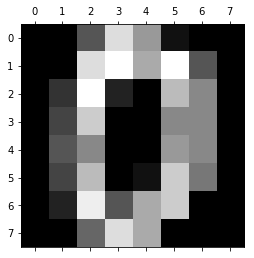

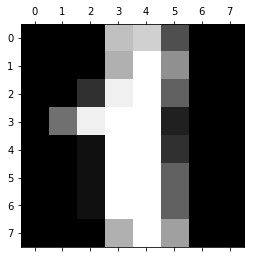

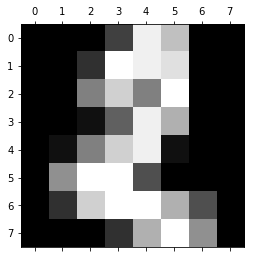

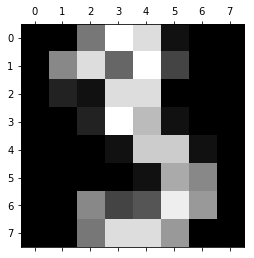

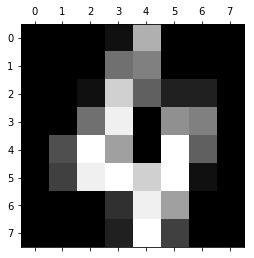

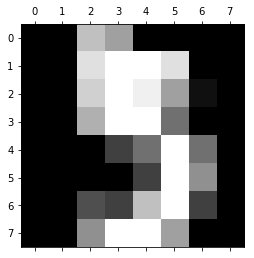

In [30]:
plt.gray()
for i in range(0, 6):
    plt.matshow(digits.images[i])
plt.show() 

Признаки и целевая переменная

In [31]:
X_digits = digits.data
Y_digits = digits.target

Разобьем данные на обучающую выборку и тест в пропорции 70/30. Возьмем алгоритм kNN и подберем для него идеальные параметры используя GridSearch.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, Y_digits, test_size=0.3, random_state=42)

In [34]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors': range(2, 25),
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': range(25,40)}
knn_GS = GridSearchCV(knn, param_grid=parameters, cv=5, scoring='accuracy', n_jobs=-1)

In [35]:
knn_GS.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': range(2, 25), 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': range(25, 40)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [36]:
knn_GS.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=25, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='distance')

In [37]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=25, metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2, weights='distance')

In [38]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=25, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

Посмотрим на метрику accuracy:

In [39]:
print('kNN train accuracy:\t', accuracy_score(y_train, knn.predict(X_train)),
      '\nkNN test accuracy:\t', accuracy_score(y_test, knn.predict(X_test)))

kNN train accuracy:	 1.0 
kNN test accuracy:	 0.9907407407407407


Прекрасные результаты! Всегда бы так.

This is  [8]


<Figure size 432x288 with 0 Axes>

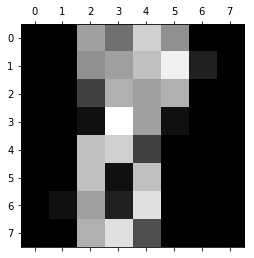

This is  [6]


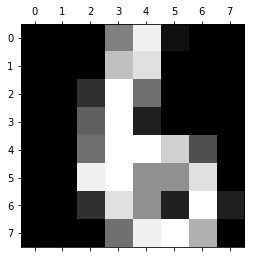

This is  [9]


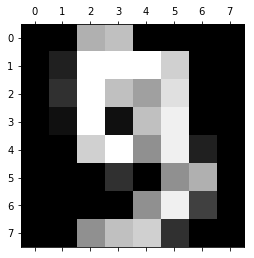

This is  [2]


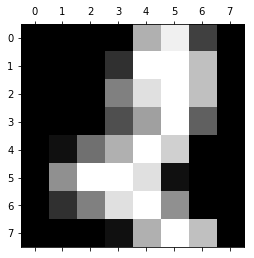

This is  [0]


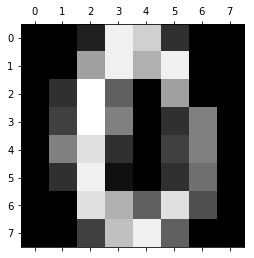

In [40]:
plt.gray()
for i in np.random.randint(0,100,5):
    print('This is ', knn.predict(digits.data[i].reshape(1, -1)))
    plt.matshow(digits.images[i])  
    plt.show() 